## Load and inspect the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
# Define column names
column_names = ['timestamp', 'activityID', 'heart_rate'] + ['IMU_hand_temp'] + ['IMU_hand_acc_16g_'+i for i in ['x', 'y', 'z']] + \
               ['IMU_hand_acc_6g_'+i for i in ['x', 'y', 'z']] + ['IMU_hand_gyro_'+i for i in ['x', 'y', 'z']] + \
               ['IMU_hand_magn_'+i for i in ['x', 'y', 'z']] + ['IMU_hand_orient_'+i for i in ['x', 'y', 'z', 'w']] + \
               ['IMU_chest_temp'] + ['IMU_chest_acc_16g_'+i for i in ['x', 'y', 'z']] + ['IMU_chest_acc_6g_'+i for i in ['x', 'y', 'z']] + \
               ['IMU_chest_gyro_'+i for i in ['x', 'y', 'z']] + ['IMU_chest_magn_'+i for i in ['x', 'y', 'z']] + \
               ['IMU_chest_orient_'+i for i in ['x', 'y', 'z', 'w']] + ['IMU_ankle_temp'] + \
               ['IMU_ankle_acc_16g_'+i for i in ['x', 'y', 'z']] + ['IMU_ankle_acc_6g_'+i for i in ['x', 'y', 'z']] + \
               ['IMU_ankle_gyro_'+i for i in ['x', 'y', 'z']] + ['IMU_ankle_magn_'+i for i in ['x', 'y', 'z']] + ['IMU_ankle_orient_'+i for i in ['x', 'y', 'z', 'w']]

In [3]:
# Load data
df = pd.read_csv('Protocol/subject101.dat', sep=' ', header=None, names=column_names)

In [4]:
# Look at the data
print(df.head())

   timestamp  activityID  heart_rate  IMU_hand_temp  IMU_hand_acc_16g_x  \
0       8.38           0       104.0           30.0             2.37223   
1       8.39           0         NaN           30.0             2.18837   
2       8.40           0         NaN           30.0             2.37357   
3       8.41           0         NaN           30.0             2.07473   
4       8.42           0         NaN           30.0             2.22936   

   IMU_hand_acc_16g_y  IMU_hand_acc_16g_z  IMU_hand_acc_6g_x  \
0             8.60074             3.51048            2.43954   
1             8.56560             3.66179            2.39494   
2             8.60107             3.54898            2.30514   
3             8.52853             3.66021            2.33528   
4             8.83122             3.70000            2.23055   

   IMU_hand_acc_6g_y  IMU_hand_acc_6g_z  ...  IMU_ankle_gyro_x  \
0            8.76165            3.35465  ...          0.008300   
1            8.55081            

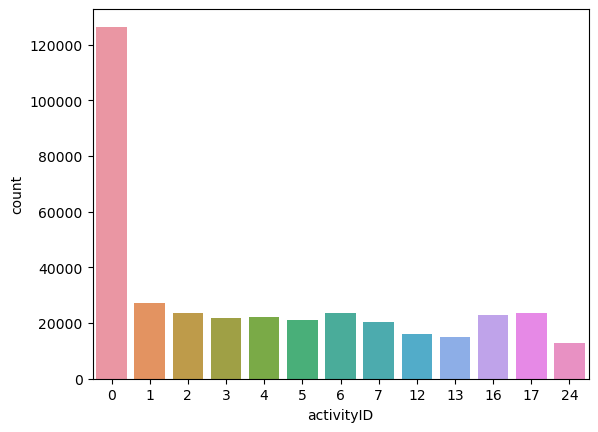

In [8]:
# Visualize activity data
sns.countplot(data=df, x='activityID')
plt.show()

## Data preprocessing

In [9]:
# Replace NaNs with mean
df.fillna(df.mean(), inplace=True)

# Remove transient activities
df = df[df['activityID'] != 0]

In [10]:
# Standardize data
scaler = StandardScaler()
df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])

In [11]:
# Split data into features and labels
X = df.iloc[:, 2:].values
y = df['activityID'].values

# One-hot encode labels
y = to_categorical(LabelEncoder().fit_transform(y))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Reshape for input into CNN
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

## Model development (CNN)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten

In [16]:
# Define CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

2023-07-18 14:50:29.951522: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-18 14:50:29.951610: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-18 14:50:29.951622: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-18 14:50:29.951821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 14:50:29.951862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2023-07-18 13:28:19.111513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 13:28:19.135323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


6249/6249 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9745

2023-07-18 13:29:16.610169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6249/6249 [==============================] - 68s 11ms/step - loss: 0.0835 - accuracy: 0.9745 - val_loss: 0.0532 - val_accuracy: 0.9869
Epoch 2/10
6249/6249 [==============================] - 65s 10ms/step - loss: 0.0918 - accuracy: 0.9846 - val_loss: 0.0989 - val_accuracy: 0.9878
Epoch 3/10
6249/6249 [==============================] - 64s 10ms/step - loss: 0.1697 - accuracy: 0.9854 - val_loss: 0.2080 - val_accuracy: 0.9864
Epoch 4/10
6249/6249 [==============================] - 63s 10ms/step - loss: 0.3082 - accuracy: 0.9857 - val_loss: 0.2610 - val_accuracy: 0.9891
Epoch 5/10
6249/6249 [==============================] - 63s 10ms/step - loss: 0.4359 - accuracy: 0.9865 - val_loss: 0.3412 - val_accuracy: 0.9924
Epoch 6/10
6249/6249 [==============================] - 63s 10ms/step - loss: 0.5758 - accuracy: 0.9873 - val_loss: 0.8021 - val_accuracy: 0.9853
Epoch 7/10
6249/6249 [==============================] - 63s 10ms/step - loss: 0.7919 - accuracy: 0.9881 - val_loss: 1.1890 - val_accura

## Model evaluation

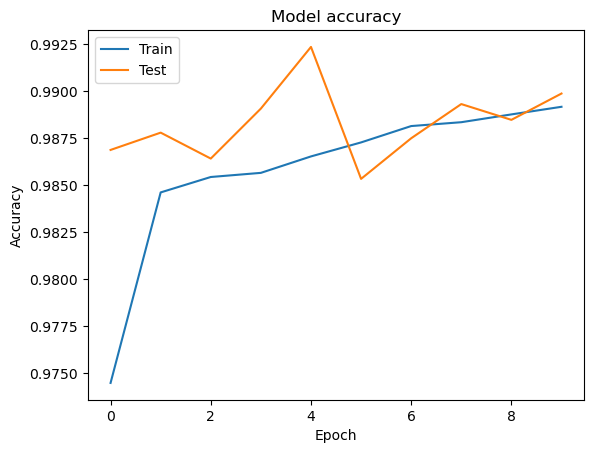

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

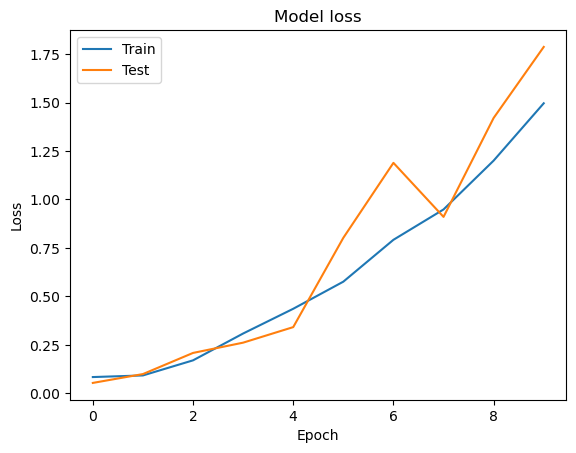

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1563/1563 [==============================] - 11s 7ms/step - loss: 1.7874 - accuracy: 0.9899
Test loss: 1.7873647212982178
Test accuracy: 0.9898783564567566


### Enhance Model with LSTM layer

In [41]:
from tensorflow.keras.layers import LSTM, Dropout

In [42]:
# Define LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2023-07-18 15:39:30.032017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 15:39:30.061561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


6249/6249 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9501

2023-07-18 15:40:34.913222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6249/6249 [==============================] - 75s 12ms/step - loss: 0.1882 - accuracy: 0.9501 - val_loss: 0.0366 - val_accuracy: 0.9913
Epoch 2/10
6249/6249 [==============================] - 71s 11ms/step - loss: 0.3265 - accuracy: 0.9743 - val_loss: 0.1199 - val_accuracy: 0.9902
Epoch 3/10
6249/6249 [==============================] - 73s 12ms/step - loss: 0.9372 - accuracy: 0.9770 - val_loss: 0.7613 - val_accuracy: 0.9812
Epoch 4/10
6249/6249 [==============================] - 70s 11ms/step - loss: 2.3896 - accuracy: 0.9788 - val_loss: 0.7640 - val_accuracy: 0.9921
Epoch 5/10
6249/6249 [==============================] - 72s 11ms/step - loss: 4.6352 - accuracy: 0.9809 - val_loss: 1.3250 - val_accuracy: 0.9919
Epoch 6/10
6249/6249 [==============================] - 73s 12ms/step - loss: 8.1916 - accuracy: 0.9817 - val_loss: 4.2160 - val_accuracy: 0.9899
Epoch 7/10
6249/6249 [==============================] - 71s 11ms/step - loss: 14.3376 - accuracy: 0.9816 - val_loss: 5.7456 - val_accur

### Evaluate the Model.


In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1563/1563 [==============================] - 12s 8ms/step - loss: 21.1873 - accuracy: 0.9916
Test loss: 21.187284469604492
Test accuracy: 0.9916186332702637


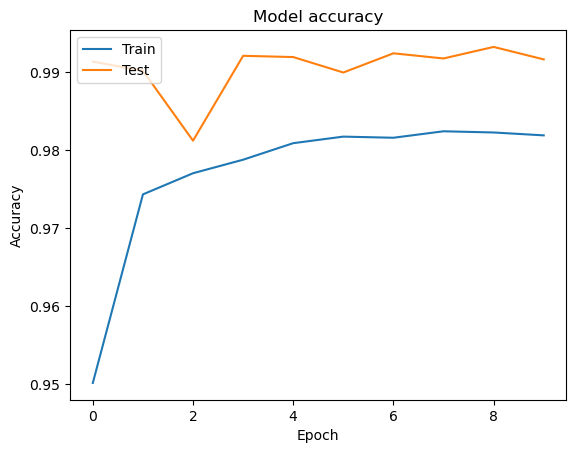

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model Prediction and Classification Report

In [54]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [48]:
# Predict on test data
y_pred = model.predict(X_test)

  74/1563 [>.............................] - ETA: 3s

2023-07-18 15:57:24.088029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 4s 2ms/step


In [57]:
def plot_confusion_matrix(confusion_mtx, classes):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d",
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

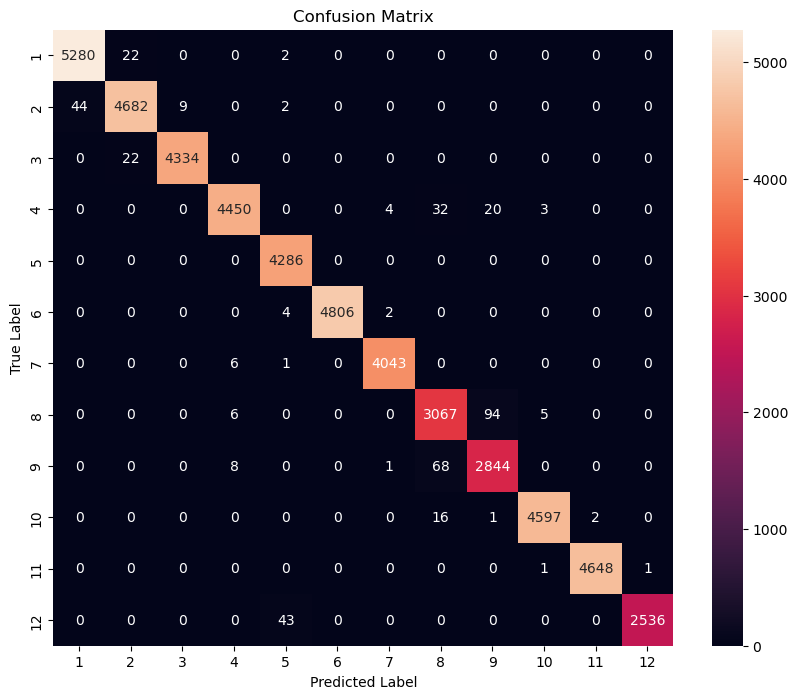

In [58]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(1, y_train.shape[1] + 1))

In [59]:
# Classification Report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5304
           1       0.99      0.99      0.99      4737
           2       1.00      0.99      1.00      4356
           3       1.00      0.99      0.99      4509
           4       0.99      1.00      0.99      4286
           5       1.00      1.00      1.00      4812
           6       1.00      1.00      1.00      4050
           7       0.96      0.97      0.97      3172
           8       0.96      0.97      0.97      2921
           9       1.00      1.00      1.00      4616
          10       1.00      1.00      1.00      4650
          11       1.00      0.98      0.99      2579

    accuracy                           0.99     49992
   macro avg       0.99      0.99      0.99     49992
weighted avg       0.99      0.99      0.99     49992

